# Pneumonia Detection using Deep Learning CNN-based Feature Extraction

In [3]:
# Install Keras Tuner
#!pip install keras tuner

In [4]:
#!pip install RandomSearch

## 1. Imports and Initial Setup
In this step, we import all the necessary libraries and prepare the environment for data processing and model building.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import keras_tuner as kt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import os

# 2. Exploratory Data Analysis (EDA)
This step involves exploring the dataset, understanding its distribution, and visualizing various aspects of the data.

### 2.1 Dataset Exploration

In [6]:
# Define paths to the data
train_path = "D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/train"
test_path = "D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/test"
val_path = "D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/val"

# List directories to check class distribution
train_classes = os.listdir(train_path)
test_classes = os.listdir(test_path)
val_classes = os.listdir(val_path)

# Display class names
print(f"Training Classes: {train_classes}")
print(f"Testing Classes: {test_classes}")
print(f"Testing Classes: {val_classes}")

# Count the number of images in each class
train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in train_classes}
test_counts = {cls: len(os.listdir(os.path.join(test_path, cls))) for cls in test_classes}
val_counts = {cls: len(os.listdir(os.path.join(val_path, cls))) for cls in val_classes}

# Display the counts
print(f"Training Counts: {train_counts}")
print(f"Testing Counts: {test_counts}")
print(f"Validation Counts: {val_counts}")


Training Classes: ['NORMAL', 'PNEUMONIA']
Testing Classes: ['NORMAL', 'PNEUMONIA']
Testing Classes: ['NORMAL', 'PNEUMONIA']
Training Counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Testing Counts: {'NORMAL': 234, 'PNEUMONIA': 390}
Validation Counts: {'NORMAL': 8, 'PNEUMONIA': 8}


### 2.2 Visualizing Class Distribution

C:\Users\Legion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


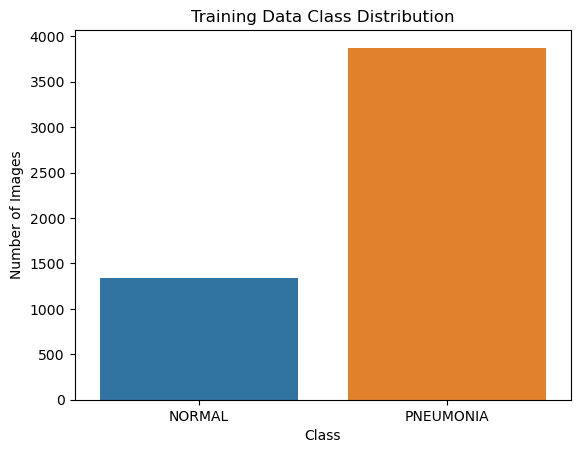

C:\Users\Legion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


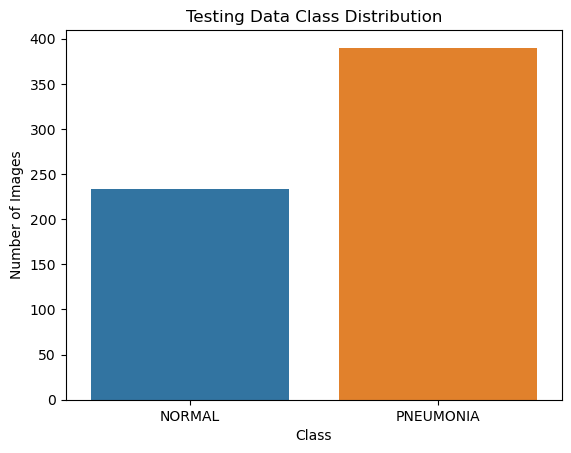

C:\Users\Legion\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


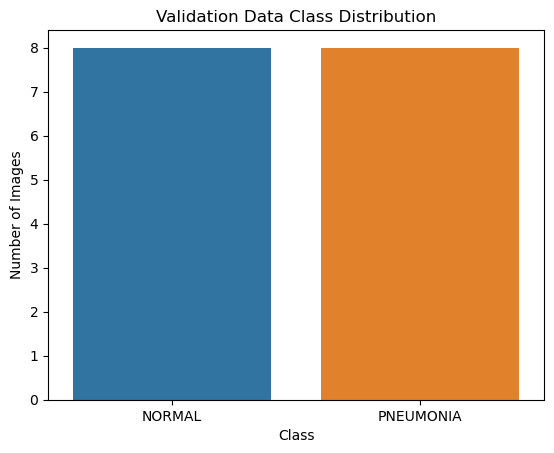

In [7]:
# Visualize class distribution
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Training Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Testing Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.title('Validation Data Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


### 2.3 Visualizing Sample Images

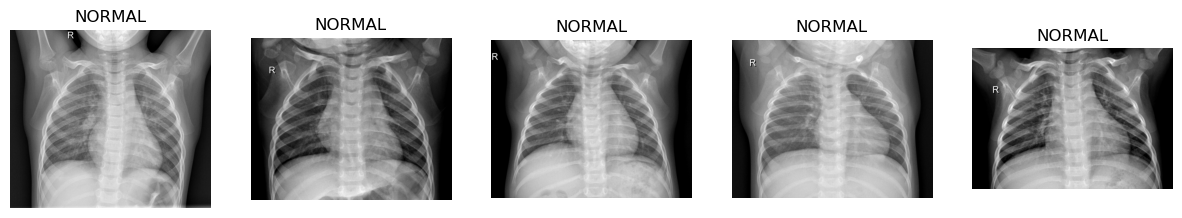

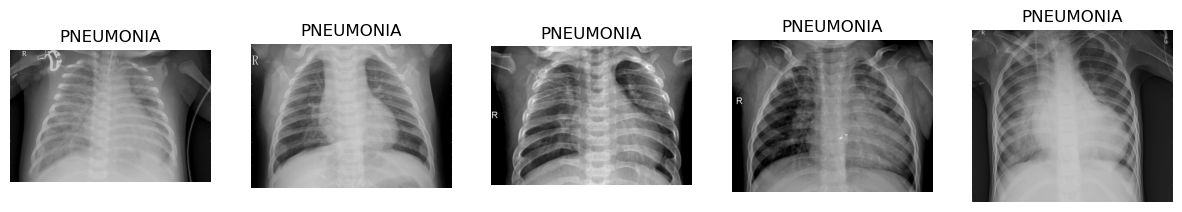

In [8]:
# Display sample images from each class
def plot_sample_images(data_path, class_name, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(os.listdir(os.path.join(data_path, class_name))[:num_images]):
        img = plt.imread(os.path.join(data_path, class_name, img_name))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Display samples
plot_sample_images(train_path, 'NORMAL')
plot_sample_images(train_path, 'PNEUMONIA')

# 3. Data Preparation

### 3.1 Data Generators with Augmentation

In [9]:
# Define constants
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 30
EPOCHS = 5

# Data generators for validation and test (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and prepare the data
train_generator = train_datagen.flow_from_directory(
    'D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for maintaining order when making predictions
)

validation_generator = validation_datagen.flow_from_directory(
    'D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# 4. Model Building.

### 4.1 Model Architecture

In [10]:
# Define the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  # First convolutional layer
    layers.MaxPooling2D((2, 2)),                                  # Max pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),                             # Second convolutional layer
    layers.MaxPooling2D(pool_size=(2, 2)),                                    # Max pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'),                             # Third convolutional layer
    layers.MaxPooling2D((2, 2)),                                              # Max pooling layer
    layers.Conv2D(128, (3, 3), activation='relu'),                            # Fourth convolutional layer
    layers.MaxPooling2D(pool_size=(2, 2)),                                    # Max pooling layer
    layers.Flatten(),                                                         # Flatten the 3D output to 1D
    layers.Dense(512, activation='relu'),                                     # Fully connected layer
    layers.Dropout(0.5),                                                      # Dropout for regularization
    layers.Dense(1, activation='sigmoid')                                     # Output layer with sigmoid activation
])

# Compile the model
model.compile(optimizer='adam',                    # Adam optimizer
              loss='binary_crossentropy',          # Binary crossentropy loss function
              metrics=['accuracy'])                # Metric: accuracy

# Print model summary
model.summary()

C:\Users\Legion\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,568,385 (36.50 MB)

 Trainable params: 9,568,385 (36.50 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Model Training

### 5.1 Training the Model

In [11]:
# Calculate the number of samples in each set
train_samples = train_generator.samples
test_samples = test_generator.samples
val_samples = validation_generator.samples

# Calculate steps
steps_per_epoch = train_samples // BATCH_SIZE
validation_steps = test_samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)   
    ]
)

Epoch 1/5


C:\Users\Legion\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8418 - loss: 0.3838 - val_accuracy: 0.7433 - val_loss: 0.7719 - learning_rate: 0.0010
Epoch 2/5
  1/173 ━━━━━━━━━━━━━━━━━━━━ 1:50 643ms/step - accuracy: 1.0000 - loss: 0.0239

C:\Users\Legion\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0239 - val_accuracy: 1.0000 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 140s 796ms/step - accuracy: 0.9553 - loss: 0.1230 - val_accuracy: 0.8033 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9667 - loss: 0.0658 - val_accuracy: 1.0000 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 137s 778ms/step - accuracy: 0.9684 - loss: 0.1009 - val_accuracy: 0.7450 - val_loss: 1.0465 - learning_rate: 0.0010


# 6. Model Evaluation

### 6.1 Evaluating the Model

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.6655 - loss: 1.6231
Test Accuracy: 81.41%


# 7 Making Predictions and Evaluation Metrics

### 7.1 Making Predictions

In [13]:
# Make predictions on the test set
predictions = model.predict(test_generator)
predictions = np.round(predictions).astype(int)  # Convert probabilities to binary predictions

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step


# 7.2 Classification Report

In [14]:
# Calculate and display various evaluation metrics
y_true = test_generator.classes  # True labels
y_pred = predictions.flatten()   # Predicted labels

# Generate a classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.98      0.51      0.67       234
   Pneumonia       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



### 7.3 Confusion Matrix

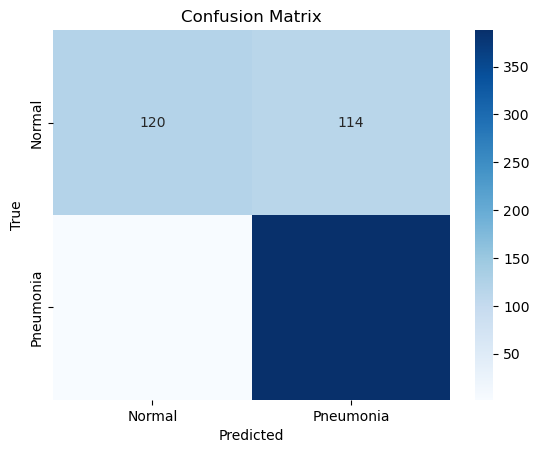

In [15]:
# Create and plot a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[120, 114],
       [  2, 388]], dtype=int64)

# 8. Visualization of Training Results

### 8.1 Training and Validation Accuracy

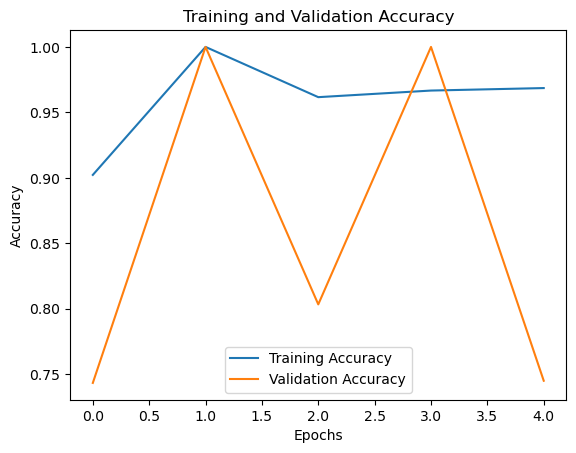

In [17]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

### 8.2 Training and Validation Loss

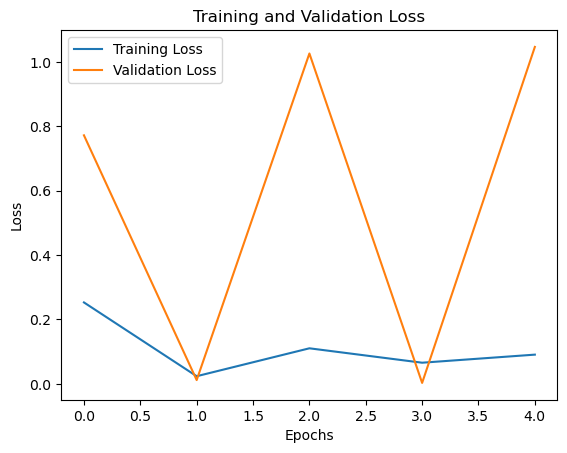

In [18]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 9. ROC Curve

### 9.1 ROC Curve and AUC

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step


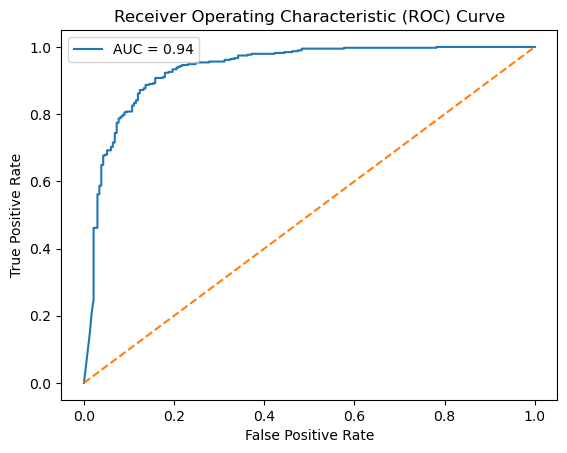

In [19]:
# Calculate and plot the ROC curve
fpr, tpr, _ = roc_curve(y_true, model.predict(test_generator))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Importing Keras Tuner

In [20]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Defining the model-building function:

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Define the model-building function with hyperparameters
def build_model(hp):
    model = tf.keras.Sequential()
    # Input layer
    model.add(layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    # Convolutional layers
    for i in range(hp.Int('num_conv_layers', 2, 4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'conv_{i}_filters', 32, 128, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D((2, 2))) 
    # Flatten layer
    model.add(layers.Flatten())
    # Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'dense_{i}_units', 64, 256, step=64),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0, 0.5, step=0.1)))  
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )  
    return model
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,705,157 (109.50 MB)

 Trainable params: 9,568,385 (36.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,136,772 (73.00 MB)

# Initializing the Keras Tuner:

In [28]:
# Initialize the Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to fit for each trial
    directory= "D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/random search result",
    project_name='pneumonia_detection'
)
# Perform the hyperparameter search
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

Reloading Tuner from D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/chest_xray/random search result\pneumonia_detection\tuner0.json


In [29]:
# Train the model with the best hyperparameters
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.7339 - loss: 0.5733

C:\Users\Legion\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 782ms/step - accuracy: 0.7342 - loss: 0.5727 - val_accuracy: 0.7500 - val_loss: 0.4014
Epoch 2/5
  1/173 ━━━━━━━━━━━━━━━━━━━━ 1:45 614ms/step - accuracy: 0.9000 - loss: 0.2263

C:\Users\Legion\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9000 - loss: 0.2263 - val_accuracy: 0.5625 - val_loss: 0.5854
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 136s 775ms/step - accuracy: 0.8956 - loss: 0.2617 - val_accuracy: 0.9375 - val_loss: 0.2073
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0416 - val_accuracy: 0.8750 - val_loss: 0.2269
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 135s 771ms/step - accuracy: 0.9492 - loss: 0.1414 - val_accuracy: 0.9375 - val_loss: 0.2265


In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print('Test accuracy:', test_acc)

# Make predictions
steps = test_generator.samples // BATCH_SIZE
predictions = model.predict(test_generator, steps=steps)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# Get true labels and ensure length consistency
true_labels = test_generator.classes[:len(predicted_classes)]

# Calculate and display classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_classes, target_names=['Normal', 'Pneumonia']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 413ms/step - accuracy: 0.5951 - loss: 1.5053
Test accuracy: 0.7866666913032532
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step
              precision    recall  f1-score   support

      Normal       0.96      0.47      0.63       234
   Pneumonia       0.75      0.99      0.85       366

    accuracy                           0.79       600
   macro avg       0.85      0.73      0.74       600
weighted avg       0.83      0.79      0.77       600



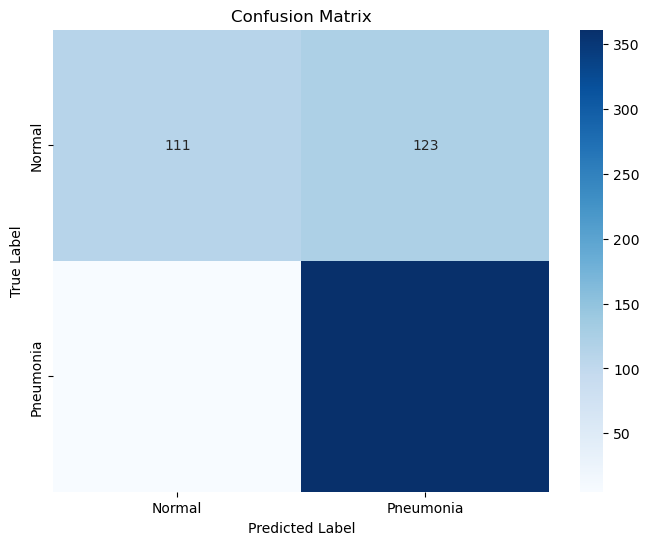

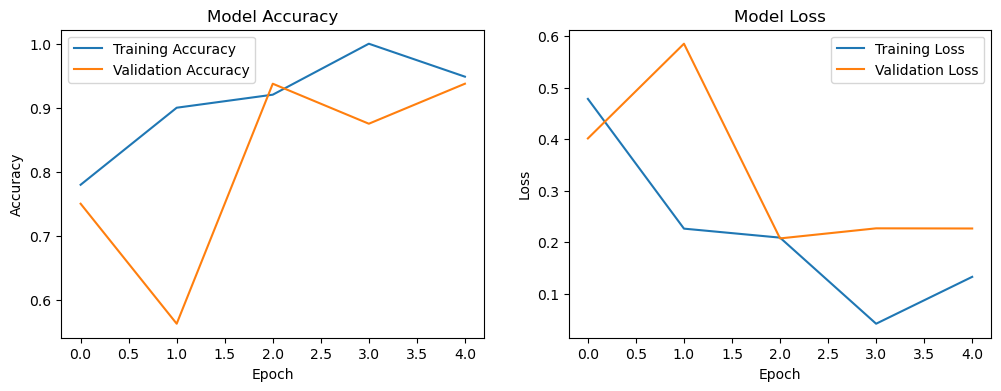

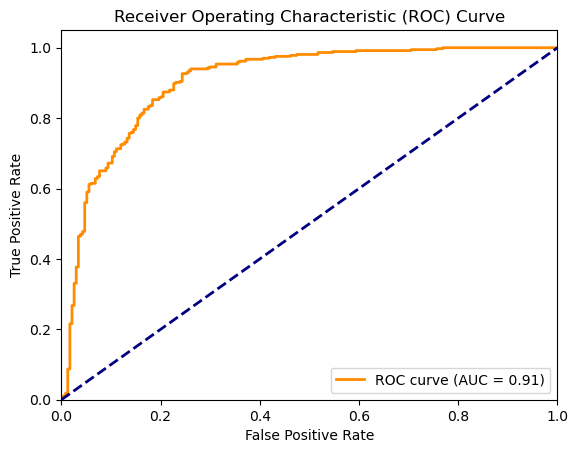

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Assuming predictions is a 1D array of probabilities
predictions_prob = predictions.flatten()

# Create and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history.get('accuracy', []), label='Training Accuracy')
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history.get('loss', []), label='Training Loss')
plt.plot(history.history.get('val_loss', []), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Testing Model Accuracy with a Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


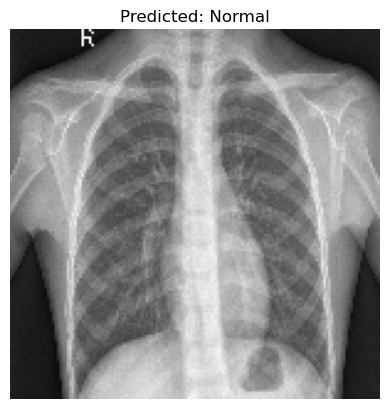

The model predicts the image is: Normal with accuracy: 0.53


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define image dimensions
IMG_HEIGHT, IMG_WIDTH = 150, 150

# Define the model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten layer to convert 2D matrix data to a 1D vector
    Flatten(),
    
    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Path to the chest X-ray image
img_path = "D:/Master Course/Sem Two/Artificial Neural Network (ANN)/Dataset/Test Image.jpeg" 

# Load the image and resize it to the required input size (150x150)
img = load_img(img_path, target_size=(150, 150))

# Load the image and resize it to the required input size (150x150)
img = load_img(img_path, target_size=(150, 150))

# Convert the image to an array and normalize it
img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction using the trained model
prediction = model.predict(img_array)

# Extract the scalar probability from the prediction array
predicted_prob = prediction[0][0]

# Interpret the prediction
predicted_class = 'Pneumonia' if predicted_prob > 0.5 else 'Normal'

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

# Print the accuracy
accuracy = predicted_prob if predicted_prob > 0.5 else 1 - predicted_prob
print(f"The model predicts the image is: {predicted_class} with accuracy: {accuracy:.2f}")